In [11]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip



# ✅ Configure Spark with Delta
builder = SparkSession.builder \
    .appName("Delta Data for ML") \
    .master("local[*]") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

# ✅ Create Spark session
spark = configure_spark_with_delta_pip(builder).getOrCreate()

# Path to your Delta table
delta_path = "data/delta_output/avg_signals_per_hour_delta"

# ✅ Load data from Delta
df = spark.read.format("delta").load(delta_path)

# ✅ Show the DataFrame
df.show(5)


+-------------------+---------------------+------------------+-------------------------------+----------------------+
|               hour|avg_LV_ActivePower_kW|avg_Wind_Speed_m_s|avg_Theoretical_Power_Curve_KWh|avg_Wind_Direction_deg|
+-------------------+---------------------+------------------+-------------------------------+----------------------+
|2018-01-01 12:00:00|   127.32581774393707|3.8977193435033097|             119.12917385221037|      230.337315877278|
|2018-01-06 07:00:00|                  0.0| 0.756321281194685|                            0.0|     213.9713846842443|
|2018-01-11 11:00:00|   1954.2926635742167|  8.69635717074076|             1961.8724117856618|    180.13876342773383|
|2018-01-14 11:00:00|                  0.0|   8.0356650352478|             1574.8318057113158|     36.15119806925452|
|2018-01-20 03:00:00|    3604.208984374998|15.235658486684116|                         3600.0|    208.16171518961514|
+-------------------+---------------------+-------------

In [9]:
import json

# Collect the 'signals' column as a list of rows
row_data = df.select('signals').limit(1).collect()

# Check if data exists before converting
if row_data:
    # Extract the first row and convert to JSON
    signals_data = row_data[0]['signals']
    signals_json = json.dumps(signals_data, indent=2)
    print(signals_json)
else:
    print("No data found in the 'signals' column.")


{
  "theo_power_curve_average": "416.328907824861",
  "wind_speed_average": "5.31133604049682",
  "wind_direction_average": "259.994903564453",
  "active_power_average": "380.047790527343"
}


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

pandas_df = df.toPandas()

# 🎯 Show the first 5 rows
print(pandas_df.head())


                  hour  avg_LV_ActivePower_kW  avg_Wind_Speed_m_s  \
0  2018-01-01 12:00:00             127.325818            3.897719   
1  2018-01-06 07:00:00               0.000000            0.756321   
2  2018-01-11 11:00:00            1954.292664            8.696357   
3  2018-01-14 11:00:00               0.000000            8.035665   
4  2018-01-20 03:00:00            3604.208984           15.235658   

   avg_Theoretical_Power_Curve_KWh  avg_Wind_Direction_deg  
0                       119.129174              230.337316  
1                         0.000000              213.971385  
2                      1961.872412              180.138763  
3                      1574.831806               36.151198  
4                      3600.000000              208.161715  


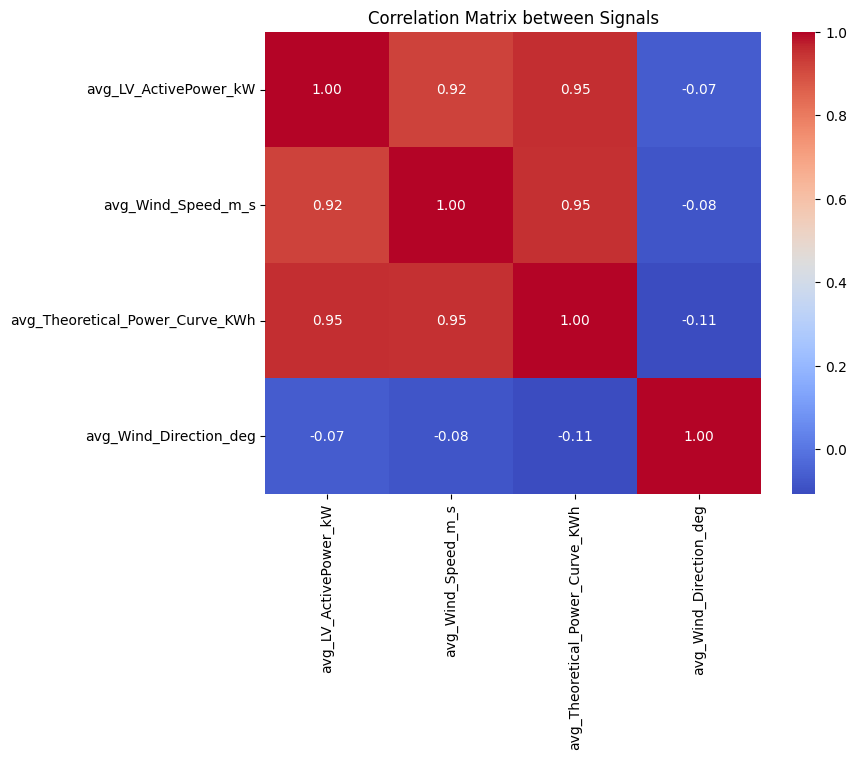

In [26]:
import seaborn as sns

# Calculate correlation matrix
correlation_matrix = pandas_df.iloc[:,1:].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix between Signals")
plt.show()


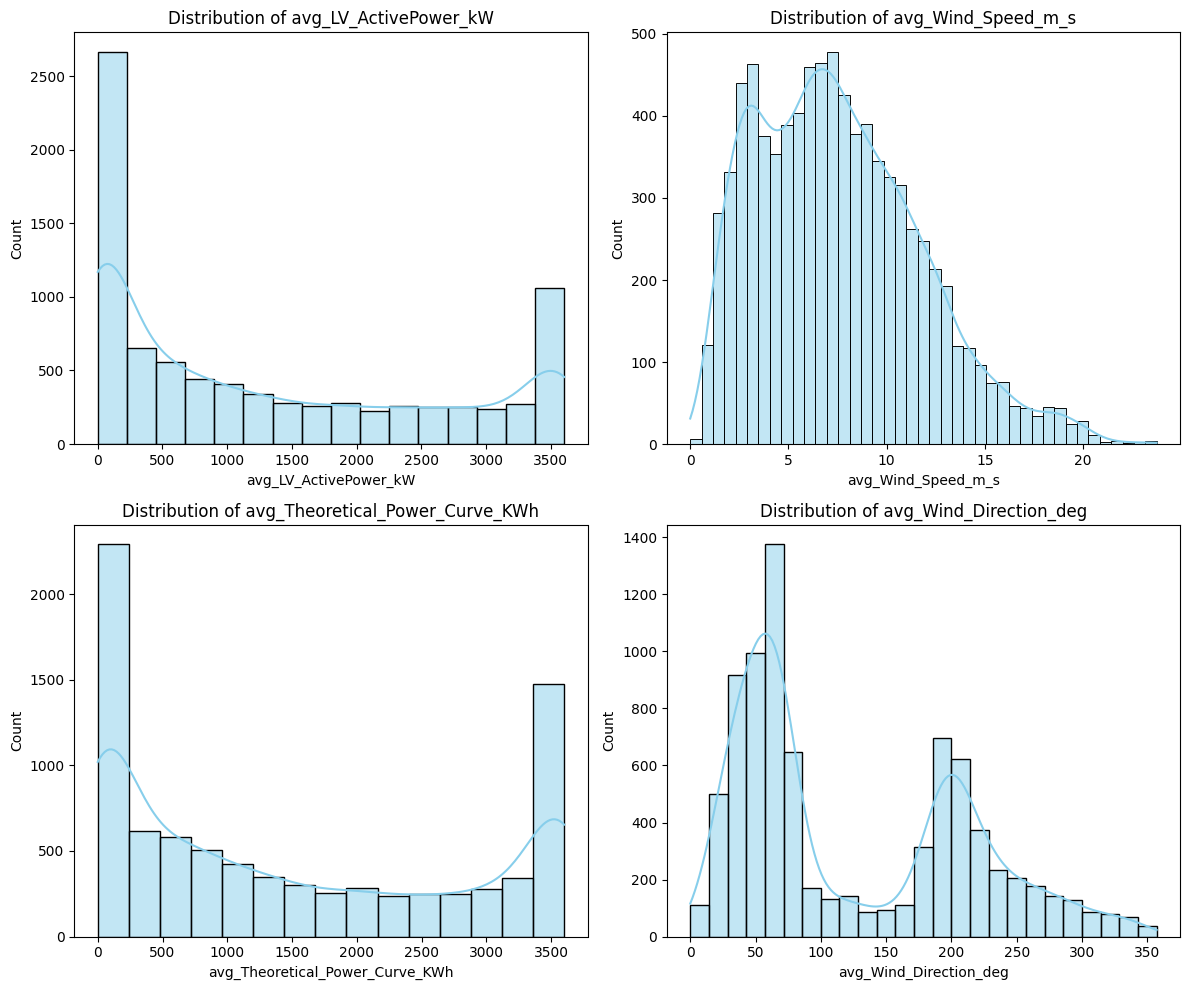

In [51]:
# List of columns to plot
columns_to_plot = [
    'avg_LV_ActivePower_kW',
    'avg_Wind_Speed_m_s',
    'avg_Theoretical_Power_Curve_KWh',
    'avg_Wind_Direction_deg'
]

# Set figure size and create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through columns and create histograms
for i, col in enumerate(columns_to_plot):
    sns.histplot(data=pandas_df, x=col, ax=axes[i], kde=True, color='skyblue')
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

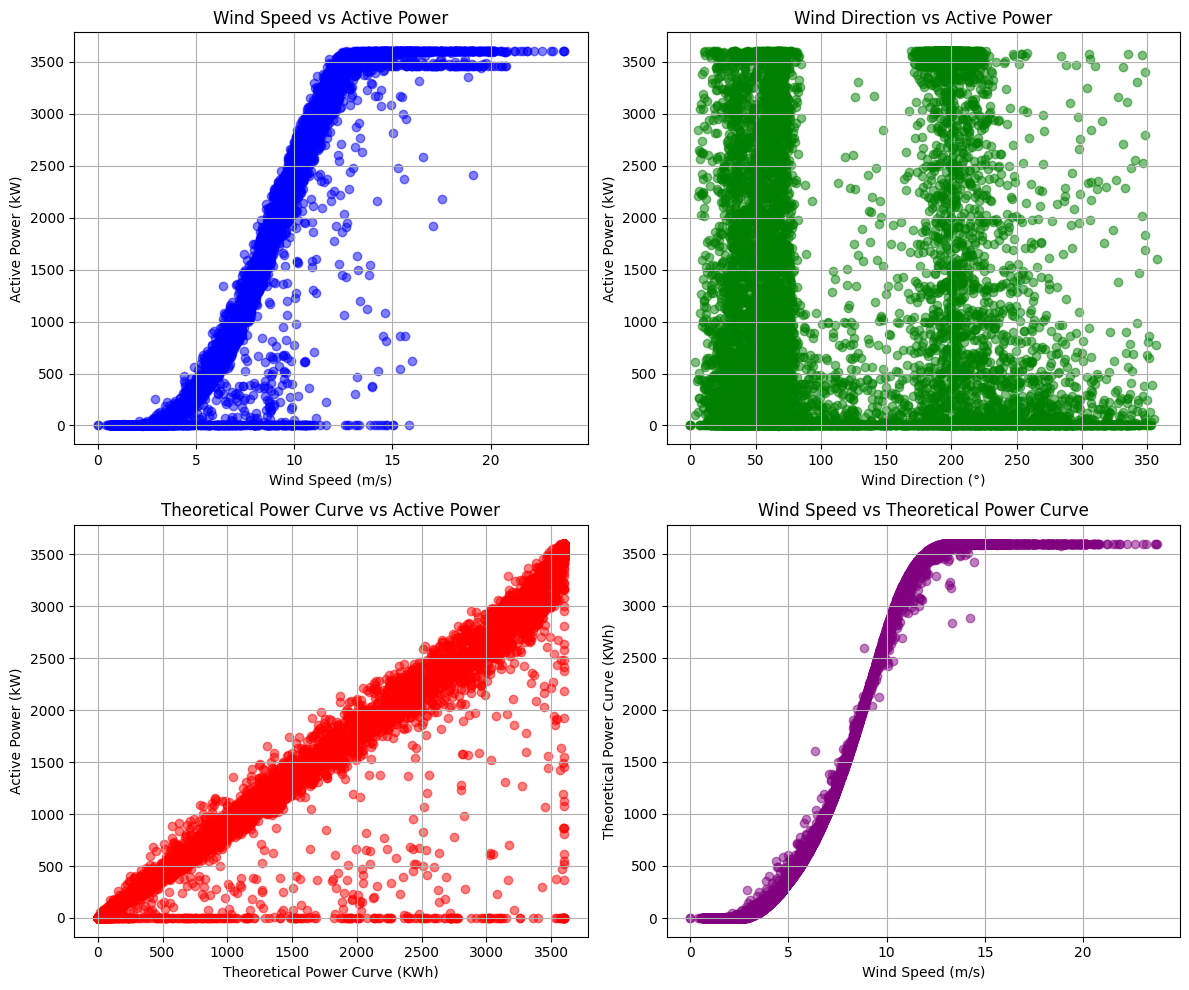

In [52]:
# Set figure size and create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten axes array for easier iteration

# Scatter plot 1: Wind Speed vs Active Power
axes[0].scatter(pandas_df['avg_Wind_Speed_m_s'], pandas_df['avg_LV_ActivePower_kW'], color='blue', alpha=0.5)
axes[0].set_title('Wind Speed vs Active Power')
axes[0].set_xlabel('Wind Speed (m/s)')
axes[0].set_ylabel('Active Power (kW)')
axes[0].grid(True)

# Scatter plot 2: Wind Direction vs Active Power
axes[1].scatter(pandas_df['avg_Wind_Direction_deg'], pandas_df['avg_LV_ActivePower_kW'], color='green', alpha=0.5)
axes[1].set_title('Wind Direction vs Active Power')
axes[1].set_xlabel('Wind Direction (°)')
axes[1].set_ylabel('Active Power (kW)')
axes[1].grid(True)

# Scatter plot 3: Theoretical Power Curve vs Active Power
axes[2].scatter(pandas_df['avg_Theoretical_Power_Curve_KWh'], pandas_df['avg_LV_ActivePower_kW'], color='red', alpha=0.5)
axes[2].set_title('Theoretical Power Curve vs Active Power')
axes[2].set_xlabel('Theoretical Power Curve (KWh)')
axes[2].set_ylabel('Active Power (kW)')
axes[2].grid(True)

# Scatter plot 4: Wind Speed vs Theoretical Power Curve
axes[3].scatter(pandas_df['avg_Wind_Speed_m_s'], pandas_df['avg_Theoretical_Power_Curve_KWh'], color='purple', alpha=0.5)
axes[3].set_title('Wind Speed vs Theoretical Power Curve')
axes[3].set_xlabel('Wind Speed (m/s)')
axes[3].set_ylabel('Theoretical Power Curve (KWh)')
axes[3].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [28]:
df.describe()

DataFrame[summary: string, hour: string, avg_LV_ActivePower_kW: string, avg_Wind_Speed_m_s: string, avg_Theoretical_Power_Curve_KWh: string, avg_Wind_Direction_deg: string]

In [29]:
df.printSchema()

root
 |-- hour: string (nullable = true)
 |-- avg_LV_ActivePower_kW: double (nullable = true)
 |-- avg_Wind_Speed_m_s: double (nullable = true)
 |-- avg_Theoretical_Power_Curve_KWh: double (nullable = true)
 |-- avg_Wind_Direction_deg: double (nullable = true)



In [40]:
from pyspark.sql.functions import col, sum

# ✅ Correct code: Count null values per column
null_counts = df.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]
).show()



+----+---------------------+------------------+-------------------------------+----------------------+
|hour|avg_LV_ActivePower_kW|avg_Wind_Speed_m_s|avg_Theoretical_Power_Curve_KWh|avg_Wind_Direction_deg|
+----+---------------------+------------------+-------------------------------+----------------------+
|   0|                    0|                 0|                              0|                     0|
+----+---------------------+------------------+-------------------------------+----------------------+



In [39]:
df.describe().show()

+-------+-------------------+---------------------+------------------+-------------------------------+----------------------+
|summary|               hour|avg_LV_ActivePower_kW|avg_Wind_Speed_m_s|avg_Theoretical_Power_Curve_KWh|avg_Wind_Direction_deg|
+-------+-------------------+---------------------+------------------+-------------------------------+----------------------+
|  count|               8439|                 8439|              8439|                           8439|                  8439|
|   mean|               NULL|    1305.538103518451| 7.551736554729743|             1490.4971341665762|    123.66784356077895|
| stddev|               NULL|   1291.3446667566886| 4.171212468724436|             1345.1166583052784|     88.21792068259722|
|    min|2018-01-01 00:00:00| -0.17952183882395334|               0.0|                            0.0|                   0.0|
|    max|2018-12-31 23:00:00|    3604.410034179685|23.746877034505165|                         3600.0|    357.26521809

In [54]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


# 🕹️ Step 1: Prepare Features
feature_cols = ["avg_Wind_Speed_m_s", "avg_Theoretical_Power_Curve_KWh", "avg_Wind_Direction_deg"]

# VectorAssembler to combine feature columns into a single 'features' column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform DataFrame to include 'features' column
df_transformed = assembler.transform(df).select("features", "avg_LV_ActivePower_kW")

# 🕹️ Step 2: Split Data into Training and Testing
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

In [56]:
# 🕹️ Step 3: Create and Fit Linear Regression Model
lr = LinearRegression(labelCol="avg_LV_ActivePower_kW", featuresCol="features", maxIter=10)

# Train the model
lr_model = lr.fit(train_data)

# Print Model Summary
training_summary = lr_model.summary
print(f"✅ Model Trained with RMSE: {training_summary.rootMeanSquaredError:.2f}")
print(f"✅ R2: {training_summary.r2:.4f}")


25/03/25 10:10:43 WARN Instrumentation: [0e10f8d5] regParam is zero, which might cause numerical instability and overfitting.
25/03/25 10:10:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/25 10:10:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


✅ Model Trained with RMSE: 375.92
✅ R2: 0.9154


In [57]:
# 🕹️ Step 4: Make Predictions on Test Data
predictions = lr_model.transform(test_data)

# Show Predictions
predictions.select("features", "avg_LV_ActivePower_kW", "prediction").show()


+--------------------+---------------------+-------------------+
|            features|avg_LV_ActivePower_kW|         prediction|
+--------------------+---------------------+-------------------+
|[0.40571998308102...|                  0.0| -87.61205066880075|
|[0.58664358655611...|                  0.0|-167.48589418425166|
|[0.61265005668004...|                  0.0|-169.42659303514722|
|[0.64935697118441...|                  0.0|-137.80857176921012|
|[0.69420332709948...|                  0.0|-184.42370411164615|
|[0.71617285907268...|                  0.0| -148.0338997433392|
|[0.73042890926201...|                  0.0|-146.73906736998924|
|[0.76139705876509...|                  0.0|-123.05810463029295|
|[0.80682105819384...|                  0.0|-117.72541678490566|
|[0.81146148840586...|                  0.0|-128.46511534125545|
|[0.81270680079857...|                  0.0|-158.73638430639795|
|[0.82566452523072...|                  0.0| -121.2895497621833|
|[0.83269222577412...|   

In [58]:
# 🕹️ Step 5: Evaluate Model Performance
evaluator = RegressionEvaluator(labelCol="avg_LV_ActivePower_kW", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

r2_evaluator = RegressionEvaluator(labelCol="avg_LV_ActivePower_kW", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)

print(f"✅ Root Mean Squared Error (RMSE) on test data: {rmse:.2f}")
print(f"✅ R2 Score on test data: {r2:.4f}")


✅ Root Mean Squared Error (RMSE) on test data: 404.81
✅ R2 Score on test data: 0.9008


In [64]:
from pyspark.sql import Row

# 📝 Define Single Row Data (replace with your desired values)
single_row_data = Row(
    avg_Wind_Speed_m_s=4.3,
    avg_Theoretical_Power_Curve_KWh=206.0,
    avg_Wind_Direction_deg=195.0
)

# 🕹️ Create a Single Row DataFrame
single_row_df = spark.createDataFrame([single_row_data])

# Show the single row
single_row_df.show()

+------------------+-------------------------------+----------------------+
|avg_Wind_Speed_m_s|avg_Theoretical_Power_Curve_KWh|avg_Wind_Direction_deg|
+------------------+-------------------------------+----------------------+
|               4.3|                          206.0|                 195.0|
+------------------+-------------------------------+----------------------+



In [65]:
# 🕹️ Use the Same Assembler as Before
single_row_transformed = assembler.transform(single_row_df).select("features")

# Show the transformed row
single_row_transformed.show(truncate=False)

# 🕹️ Use Model to Predict on Single Row
single_row_prediction = lr_model.transform(single_row_transformed)

# Show Prediction Result
single_row_prediction.select("features", "prediction").show()

+-----------------+
|features         |
+-----------------+
|[4.3,206.0,195.0]|
+-----------------+

+-----------------+------------------+
|         features|        prediction|
+-----------------+------------------+
|[4.3,206.0,195.0]|180.42588250211477|
+-----------------+------------------+

